## Text similarity experiment

Requires results from ```scripts/stability.py```

Produces Figure 3 and 12.

In [7]:
import pandas as pd
import Levenshtein as lv
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image

In [2]:
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,geometry}'
mpl.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams.update({
    'font.family':'serif',
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "font.size": 45,
    "figure.figsize":(13,8),
    "lines.markersize": 20
})
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

Functions to calculate the edit distance

In [3]:
def prefix(row):
    prefix=[]
    for j in range(len(row['interventions'])):
        prefix.append(len("".join([row['token_list'][x] for x in row['token_list'] if int(x)<row['interventions'][j]])))
    return prefix

def edit_distance_lv(row, intervention=None):
    if intervention or intervention==0:
        # Condition on a single intervention
        n_interventions=1
    else:
        n_interventions = len(row['interventions'])
    edit_distance_cf = np.zeros(n_interventions)
    edit_distance_prior = np.zeros(n_interventions)
    fact = row['factual_response']

    for j in range(n_interventions):
        if intervention or intervention==0:
            cf = row['cf_response'][min(intervention,len(row['interventions']) - 1 )]
            prior = row['prior_response'][min(intervention,len(row['interventions']) - 1)]
            prefix = row['prefix'][min(intervention, len(row['interventions']) - 1)]
        else:
            cf = row['cf_response'][j]
            prior = row['prior_response'][j]
            prefix = row['prefix'][j]
        try:
            edit_distance_cf[j] = lv.distance(fact,cf) / max(len(fact[prefix:]), len(cf[prefix:]))
            edit_distance_prior[j] = lv.distance(fact,prior) / max(len(fact[prefix:]), len(prior[prefix:]))
        except(ZeroDivisionError):
            edit_distance_cf[j]=0
            edit_distance_prior[j]=0
    return edit_distance_cf, edit_distance_prior


Read input

In [4]:
root_dir='../'
output_dir=f'{root_dir}figures/edit_distance/'
model_family=['llama3','mistral']
input_file_llama3=f"{root_dir}outputs/stability/{model_family[0]}/stability_strings"
input_file_mistral=f"{root_dir}outputs/stability/{model_family[1]}/stability_strings"

df_llama3=pd.read_parquet(f"{input_file_llama3}.parquet", engine='fastparquet')
df_mistral=pd.read_parquet(f"{input_file_mistral}.parquet", engine='fastparquet')
df_orig_llama3=df_llama3.copy()
df_orig_mistral=df_mistral.copy()

Prepare results to plot

In [5]:
def edit_distance_vs_param(df,param='temperature'):
    if param=='temperature':
        df=df[df['sampler_type'].isin(['vocabulary','categorical'])]
        var_to_plot='temperature'
    elif param=='p':
        df=df[df['temperature'].isin([0.6])]
        df=df[df['sampler_type'].isin(['top-p token','vocabulary'])]
        df['sampler_param']=df['sampler_param'].replace([0],[1])
        var_to_plot='sampler_param'
    elif param=='k':
        df=df[df['temperature'].isin([0.6])]
        df=df[df['sampler_type'].isin(['top-k token','vocabulary'])]
        df['sampler_param']=df['sampler_param'].replace([0],[128256])
        var_to_plot='sampler_param'

    ints = df['interventions'].apply(lambda x: len(x))
    df=df.copy()
    df['prefix']=df.apply(prefix,axis=1)
    df=df.reset_index()

    df[['Counterfactual Token Generation','Interventional Token Generation']] = df.apply(edit_distance_lv, axis=1, result_type='expand')

    results = df[['Counterfactual Token Generation','Interventional Token Generation',var_to_plot]].explode(['Counterfactual Token Generation','Interventional Token Generation'])
        

    res_to_plot = results.melt(id_vars=[var_to_plot], 
                                value_vars=['Counterfactual Token Generation','Interventional Token Generation'],
                                var_name='method',
                                value_name='edit_distance')
    return results

In [6]:
vars_to_plot=['temperature','p','k']

results_llama3={var_to_plot:edit_distance_vs_param(df_orig_llama3.copy(),var_to_plot) for var_to_plot in vars_to_plot}
results_cf_llama3={var_to_plot:0 for var_to_plot in vars_to_plot}
results_interv_llama3={var_to_plot:0 for var_to_plot in vars_to_plot}

results_cf_llama3['temperature']=results_llama3['temperature'][['temperature','Counterfactual Token Generation']]
results_interv_llama3['temperature']=results_llama3['temperature'][['temperature','Interventional Token Generation']]
results_cf_llama3['p']=results_llama3['p'][['sampler_param','Counterfactual Token Generation']]
results_interv_llama3['p']=results_llama3['p'][['sampler_param','Interventional Token Generation']]
results_cf_llama3['k']=results_llama3['k'][['sampler_param','Counterfactual Token Generation']]
results_interv_llama3['k']=results_llama3['k'][['sampler_param','Interventional Token Generation']]

results_mistral={var_to_plot:edit_distance_vs_param(df_orig_mistral.copy(),var_to_plot) for var_to_plot in vars_to_plot}
results_cf_mistral={var_to_plot:0 for var_to_plot in vars_to_plot}
results_interv_mistral={var_to_plot:0 for var_to_plot in vars_to_plot}

results_cf_mistral['temperature']=results_mistral['temperature'][['temperature','Counterfactual Token Generation']]
results_interv_mistral['temperature']=results_mistral['temperature'][['temperature','Interventional Token Generation']]
results_cf_mistral['p']=results_mistral['p'][['sampler_param','Counterfactual Token Generation']]
results_interv_mistral['p']=results_mistral['p'][['sampler_param','Interventional Token Generation']]
results_cf_mistral['k']=results_mistral['k'][['sampler_param','Counterfactual Token Generation']]
results_interv_mistral['k']=results_mistral['k'][['sampler_param','Interventional Token Generation']]

### Figure 3

To produce figure 3 without the LLM logos, set `icons=False`. \
Otherwise, download the logos from here:
- [llama icon](https://www.flaticon.com/free-icon/llama_3284124)
- [mistral icon](https://www.stickpng.com/img/icons-logos-emojis/ai-tools/mistral-ai-icon-logo)

Save the icons in `notebooks\llama.png` and `notebooks\mistral.png`

In [10]:
def plot_edit_distance_vs_param(results_cf1,
                                results_interv1,
                                results_cf2,
                                results_interv2,
                                output_dir,
                                param='temperature',
                                icons=False):
    if param=='temperature':
        var_to_plot='temperature'
        xlabel=r'$\tau$'
        xticks=[0.0,0.2,0.4,0.6,0.8,1.0]
        xticklabels=['0.0','0.2','0.4','0.6','0.8','1.0']
        xlims=[-0.05,1.05]
        file_name='tau_vs_ed'
    elif param=='p':
        var_to_plot='sampler_param'
        xlabel=r'$p$'
        xticks=[0.75,0.8,0.85,0.9,0.95,1]
        xticklabels=['0.75','0.80','0.85','0.90','0.95','1.00']
        xlims=[0.74,1.01]
        file_name='p_vs_ed'
    elif param=='k':
        var_to_plot='sampler_param'
        xlabel=r'$k$'
        xticks=[1,10,100,1000,10000,100000]
        xticklabels=[r'$1$',r'$10$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$']
        xlims=[0.9,160000]
        file_name='k_vs_ed'
    if icons:
        llama_logo = Image.open('llama.png')
        mistral_logo = Image.open('mistral.png')

    res_to_plot_cf1 = results_cf1.melt(id_vars=[var_to_plot], value_vars=['Counterfactual Token Generation'],
                                       var_name='method',value_name='edit_distance')
    res_to_plot_interv1 = results_interv1.melt(id_vars=[var_to_plot], value_vars=['Interventional Token Generation'],
                                       var_name='method', value_name='edit_distance')
    res_to_plot_cf2 = results_cf2.melt(id_vars=[var_to_plot], value_vars=['Counterfactual Token Generation'],
                                        var_name='method', value_name='edit_distance')
    res_to_plot_interv2 = results_interv2.melt(id_vars=[var_to_plot], value_vars=['Interventional Token Generation'],
                                    var_name='method', value_name='edit_distance')
    
    fig,ax=plt.subplots()

    sns.lineplot(data=res_to_plot_cf1, ax=ax, x=var_to_plot, y='edit_distance', estimator='mean',
                hue='method', palette=["#08b5c4"], style=True, markers='o', dashes=False, markeredgecolor=None)
    sns.lineplot(data=res_to_plot_cf2, ax=ax, x=var_to_plot, y='edit_distance', estimator='mean',
                hue='method', palette=["#ff7f0e"], style=True, markers='o', dashes=False, markeredgecolor=None)
    sns.lineplot(data=res_to_plot_interv1, ax=ax, x=var_to_plot, y='edit_distance', estimator='mean',
                hue='method', palette=["#8ce5ed"], style=True, markers='^', dashes=[(4,4)], alpha=0.8, markeredgecolor=None)
    sns.lineplot(data=res_to_plot_interv2, ax=ax, x=var_to_plot, y='edit_distance', estimator='mean',
                hue='method', palette=["#f0a665"], style=True, markers='^', dashes=[(4,4)], alpha=0.8, markeredgecolor=None)

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Edit Distance')
    ax.get_legend().remove()
    ax.spines[['right', 'top']].set_visible(False)
    if param=='k':
        ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_yticks([0.45,0.50,0.55,0.60,0.65,0.70,0.75])
    ax.set_yticklabels(['0.45','0.50','0.55','0.60','0.65','0.70','0.75'])
    ax.set_ylim(0.44,0.76)

    if icons:
        if param=='temperature':
            ax.annotate('', xy=(0.3, 0.63), xytext=(0.25, 0.67), arrowprops=dict(facecolor='#ff7f0e', edgecolor='none', width=5, headwidth=15)) # mistral
            ax.annotate('', xy=(0.5, 0.52), xytext=(0.6, 0.5), arrowprops=dict(facecolor='#08b5c4', edgecolor='none', width=5, headwidth=15))  # llama
            
            # x, y, x_size, y_size (in general figure coordinates)
            ax_mistral_image = ax.inset_axes([0.15, 0.75, 0.15, 0.15])
            ax_mistral_image.imshow(mistral_logo)
            ax_mistral_image.axis('off')

            ax_llama_image = ax.inset_axes([0.57, 0.1, 0.15, 0.15])
            ax_llama_image.imshow(llama_logo)
            ax_llama_image.axis('off')
        elif param=='p':
            ax.annotate('', xy=(0.86, 0.66), xytext=(0.84, 0.68), arrowprops=dict(facecolor='#ff7f0e', edgecolor='none', width=5, headwidth=15)) # mistral
            ax.annotate('', xy=(0.87, 0.51), xytext=(0.89, 0.49), arrowprops=dict(facecolor='#08b5c4', edgecolor='none', width=5, headwidth=15))  # llama
            
            # x, y, x_size, y_size (in general figure coordinates)
            ax_mistral_image = ax.inset_axes([0.23, 0.73, 0.15, 0.15])
            ax_mistral_image.imshow(mistral_logo)
            ax_mistral_image.axis('off')

            ax_llama_image = ax.inset_axes([0.53, 0.05, 0.15, 0.15])
            ax_llama_image.imshow(llama_logo)
            ax_llama_image.axis('off')

        elif param=='k':
            ax.annotate('', xy=(50, 0.69), xytext=(20, 0.71), arrowprops=dict(facecolor='#ff7f0e', edgecolor='none', width=5, headwidth=15)) # mistral
            ax.annotate('', xy=(400, 0.53), xytext=(1000, 0.51), arrowprops=dict(facecolor='#08b5c4', edgecolor='none', width=5, headwidth=15))  # llama

            # x, y, x_size, y_size (in general figure coordinates)
            ax_mistral_image = ax.inset_axes([0.11, 0.81, 0.15, 0.15])
            ax_mistral_image.imshow(mistral_logo)
            ax_mistral_image.axis('off')

            ax_llama_image = ax.inset_axes([0.55, 0.1, 0.15, 0.15])
            ax_llama_image.imshow(llama_logo)
            ax_llama_image.axis('off')

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(f'{output_dir}{file_name}.pdf',bbox_inches='tight')
    print(f'Saved figure at {output_dir}{file_name}.pdf')

def plot_legend(output_dir):
    fig,ax1=plt.subplots()
    ax1.plot([0,1],[0,1],color='grey',marker='^',linestyle='dashed',dashes=(4,4),label='Interventional Token Generation',alpha=0.8)
    ax1.plot([0,1],[0,1],color='grey',marker='o',label='Counterfactual Token Generation')
    plt.close()
    fig,ax=plt.subplots(figsize=(36,1))
    ax.legend(*ax1.get_legend_handles_labels(),ncol=2,frameon=False, loc='center')
    ax.spines[['right', 'top','left','bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(f'{output_dir}legend.pdf',bbox_inches='tight')

Saved figure at ../figures/edit_distance/tau_vs_ed.pdf
Saved figure at ../figures/edit_distance/p_vs_ed.pdf
Saved figure at ../figures/edit_distance/k_vs_ed.pdf


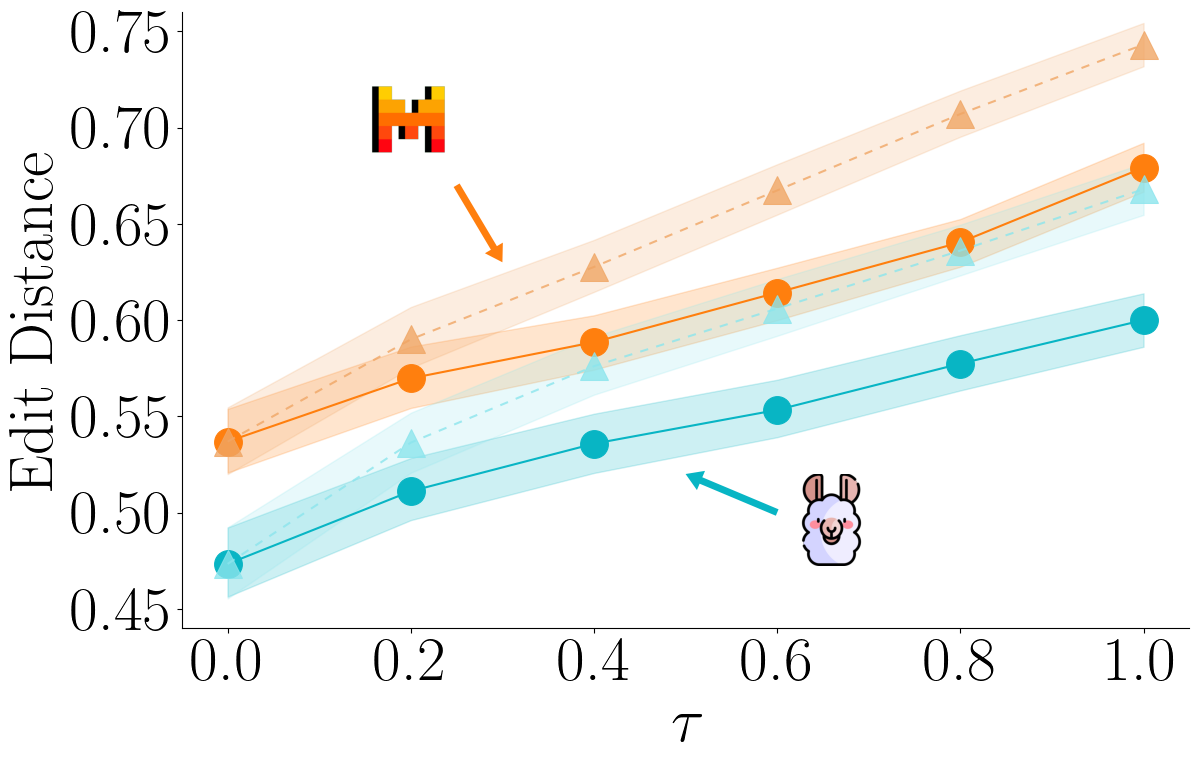

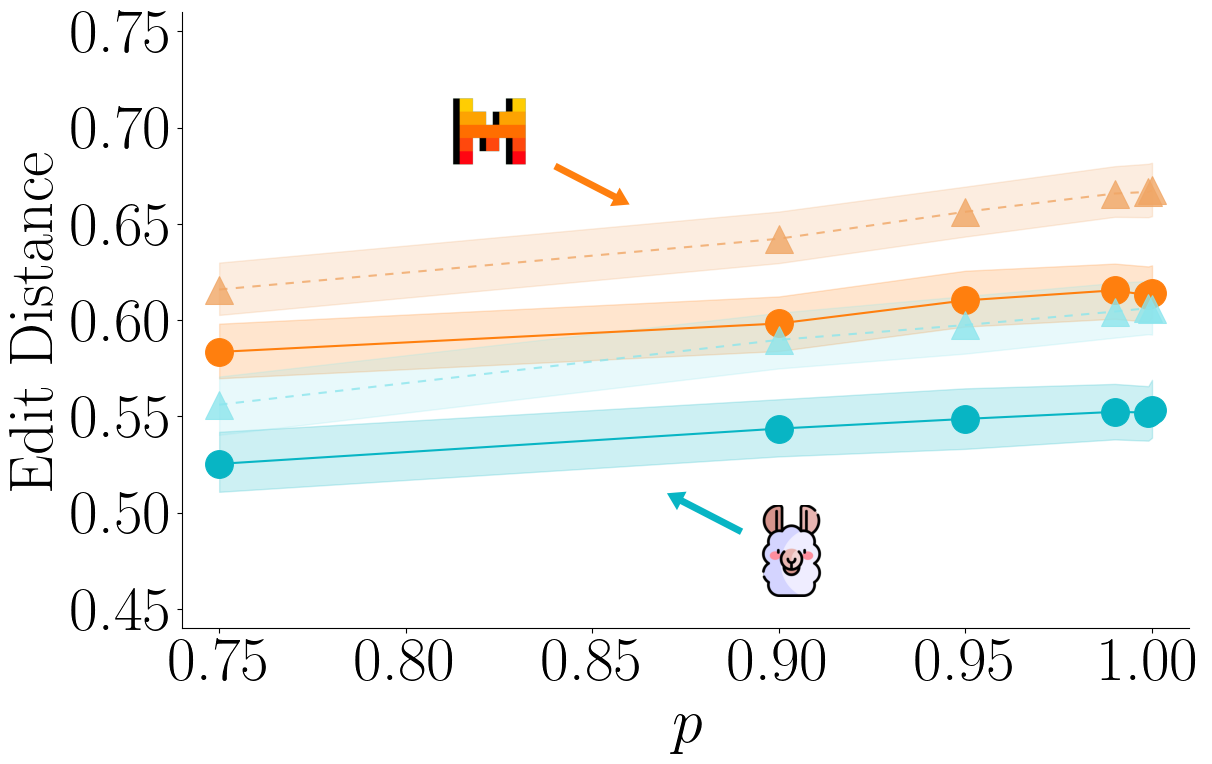

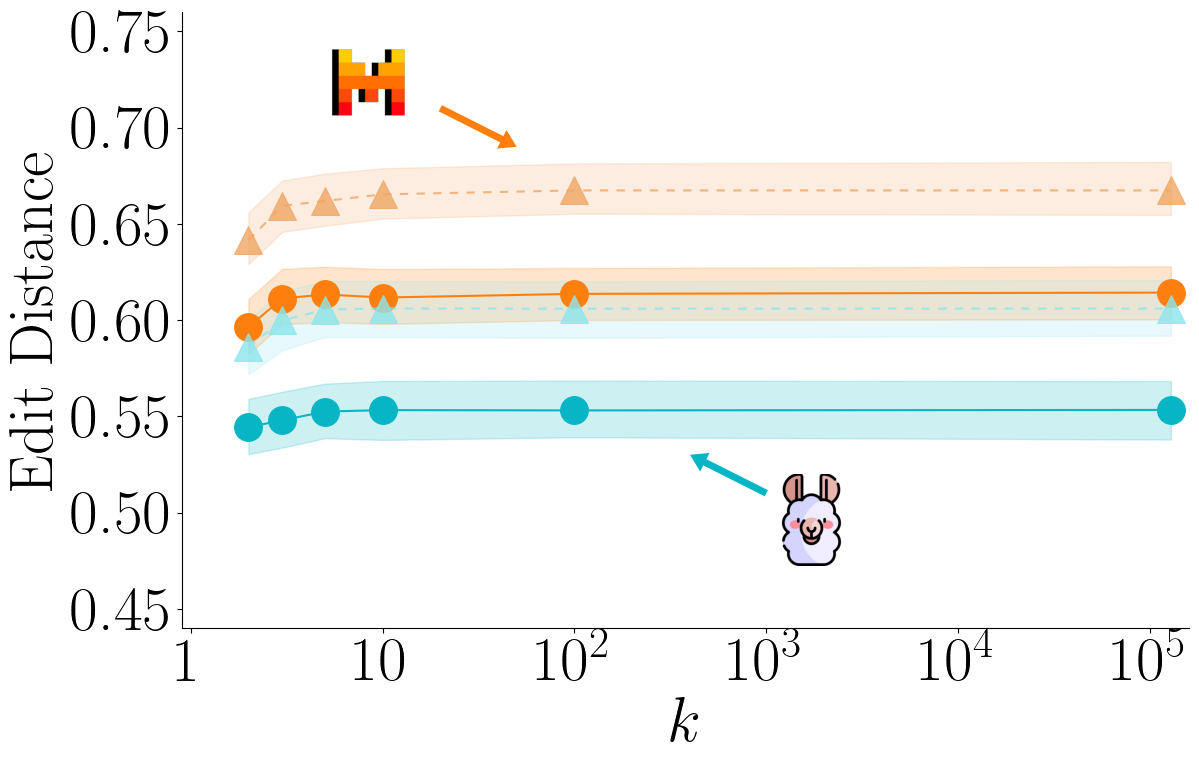

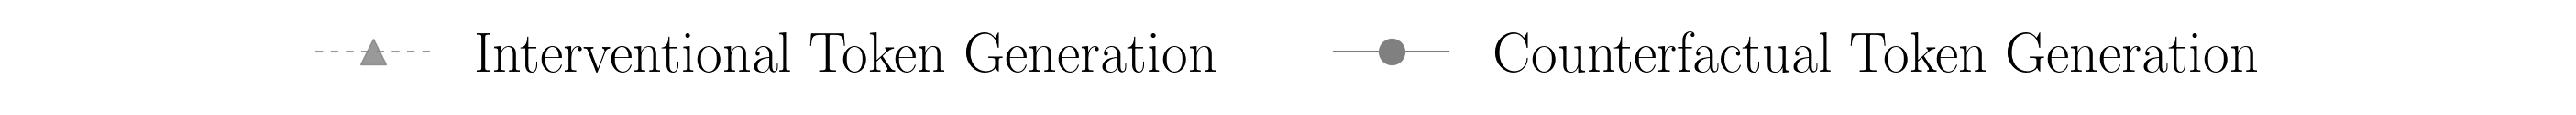

In [11]:
for var_to_plot in vars_to_plot:
        plot_edit_distance_vs_param(results_cf1=results_cf_llama3[var_to_plot],
                                        results_cf2=results_cf_mistral[var_to_plot],
                                        results_interv1=results_interv_llama3[var_to_plot],
                                        results_interv2=results_interv_mistral[var_to_plot],
                                        output_dir=output_dir,
                                        param=var_to_plot,
                                        icons=True) # set icons=False to remove logos
plot_legend(output_dir=output_dir)

### Figure 12

In [12]:
def plot_edit_distance_vs_param_categorical(results_cf1,
                                results_interv1,
                                results_cf2,
                                results_interv2,
                                output_dir,
                                param='temperature'):
    if param=='temperature':
        var_to_plot='temperature'
        xlabel=r'$\tau$'
        xticks=[0.0,0.2,0.4,0.6,0.8,1.0]
        xticklabels=['0.0','0.2','0.4','0.6','0.8','1.0']
        xlims=[-0.05,1.05]
        file_name='tau_vs_ed'
    elif param=='p':
        var_to_plot='sampler_param'
        xlabel=r'$p$'
        xticks=[0.75,0.8,0.85,0.9,0.95,1]
        xticklabels=['0.75','0.80','0.85','0.90','0.95','1.00']
        xlims=[0.74,1.01]
        file_name='p_vs_ed'
    elif param=='k':
        var_to_plot='sampler_param'
        xlabel=r'$k$'
        xticks=[1,10,100,1000,10000,100000]
        xticklabels=[r'$1$',r'$10$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$']
        xlims=[0.9,160000]
        file_name='k_vs_ed'
    file_name=file_name+'_categorical'

    res_to_plot_cf1 = results_cf1.melt(id_vars=[var_to_plot], value_vars=['Counterfactual Token Generation'],
                                       var_name='method',value_name='edit_distance')
    res_to_plot_interv1 = results_interv1.melt(id_vars=[var_to_plot], value_vars=['Interventional Token Generation'],
                                       var_name='method', value_name='edit_distance')
    res_to_plot_cf2 = results_cf2.melt(id_vars=[var_to_plot], value_vars=['Counterfactual Token Generation'],
                                        var_name='method', value_name='edit_distance')
    res_to_plot_interv2 = results_interv2.melt(id_vars=[var_to_plot], value_vars=['Interventional Token Generation'],
                                       var_name='method', value_name='edit_distance')
    
    y1,y2,y3,y4,yerr1,yerr2,yerr3,yerr4=[],[],[],[],[],[],[],[]
    x=res_to_plot_cf1[var_to_plot].unique()
    offset=0.039
    offsets=[-offset,0,offset,2*offset]
    for t in res_to_plot_cf1[var_to_plot].unique():
        cf_t=res_to_plot_cf1[res_to_plot_cf1[var_to_plot]==t]
        y1.append(cf_t['edit_distance'].mean())
        yerr1.append(cf_t['edit_distance'].std()*1.96/np.sqrt(len(cf_t)))
        cf_t=res_to_plot_cf2[res_to_plot_cf2[var_to_plot]==t]
        y2.append(cf_t['edit_distance'].mean())
        yerr2.append(cf_t['edit_distance'].std()*1.96/np.sqrt(len(cf_t)))
        cf_t=res_to_plot_interv1[res_to_plot_interv1[var_to_plot]==t]
        y3.append(cf_t['edit_distance'].mean())
        yerr3.append(cf_t['edit_distance'].std()*1.96/np.sqrt(len(cf_t)))
        cf_t=res_to_plot_interv2[res_to_plot_interv2[var_to_plot]==t]
        y4.append(cf_t['edit_distance'].mean())
        yerr4.append(cf_t['edit_distance'].std()*1.96/np.sqrt(len(cf_t)))
    # exit(0)

    fig,ax=plt.subplots()

    cols=sns.husl_palette(6)
    plt.errorbar([t+offsets[0] for t in x],y1,yerr1,fmt='o',color=cols[3],
                 elinewidth=4,capsize=8,capthick=4)
    plt.errorbar([t+offsets[1] for t in x],y2,yerr2,fmt='s',color=cols[1],
                 elinewidth=4,capsize=8,capthick=4)
    plt.errorbar([t+offsets[2] for t in x],y3,yerr3,fmt='^',color=cols[5],
                 elinewidth=4,capsize=8,capthick=4)
    plt.errorbar([t+offsets[3] for t in x],y4,yerr4,fmt='X',color=cols[2],
                 elinewidth=4,capsize=8,capthick=4)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Edit Distance')
    cols=sns.color_palette("husl", 6)
    fig,ax1=plt.subplots()
    ax1.plot([0,1],[0,1],color=cols[2],marker='X',linestyle='',label='Interventional (ITS)')
    ax1.plot([0,1],[0,1],color=cols[5],marker='^',linestyle='',label='Interventional (GM)')
    ax1.plot([0,1],[0,1],color=cols[1],marker='s',linestyle='',label='Counterfactual (ITS)')
    ax1.plot([0,1],[0,1],color=cols[3],marker='o',linestyle='',label='Counterfactual (GM)')
    plt.close()
    ax.legend(*ax1.get_legend_handles_labels(),ncol=1,loc='center right',handletextpad=0.1,bbox_to_anchor=(1.8,0.5))
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xlims[0]-0.02,xlims[1]+0.06)
    ax.set_yticks([0.45,0.50,0.55,0.60,0.65,0.70,0.75])
    ax.set_yticklabels(['0.45','0.50','0.55','0.60','0.65','0.70','0.75'])
    ax.set_ylim(0.44,0.76)
    plt.savefig(f'{output_dir}{file_name}.pdf',bbox_inches='tight')
    print(f'Saved figure at {output_dir}{file_name}.pdf')

In [13]:
input_dir=f"{root_dir}outputs/stability/categorical"

input_file_categorical=f"{input_dir}/stability_strings"
df_categorical=pd.read_parquet(f"{input_file_categorical}.parquet", engine='fastparquet')

df_orig_categorical=df_categorical.copy()

vars_to_plot=['temperature']
results_categorical={var_to_plot:edit_distance_vs_param(df_orig_categorical.copy(),var_to_plot) for var_to_plot in vars_to_plot}
results_cf_categorical={var_to_plot:0 for var_to_plot in vars_to_plot}
results_interv_categorical={var_to_plot:0 for var_to_plot in vars_to_plot}

results_cf_categorical['temperature']=results_categorical['temperature'][['temperature','Counterfactual Token Generation']]
results_interv_categorical['temperature']=results_categorical['temperature'][['temperature','Interventional Token Generation']]

Saved figure at ../figures/edit_distance/tau_vs_ed_categorical.pdf


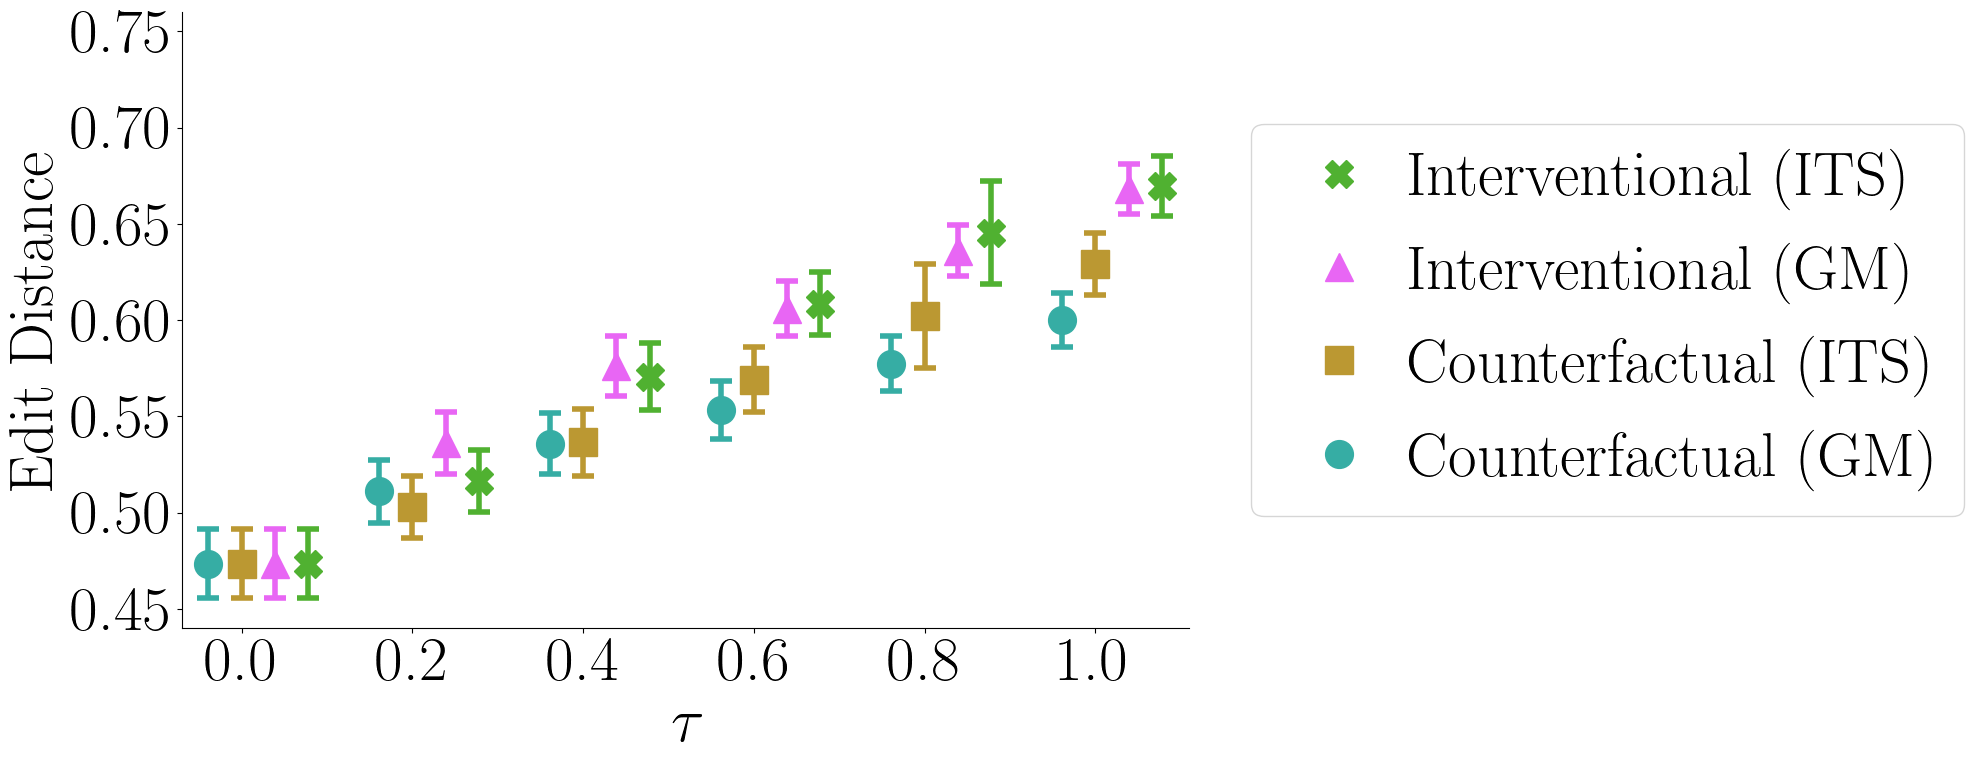

In [14]:
plot_edit_distance_vs_param_categorical(results_cf1=results_cf_llama3['temperature'],
                                        results_cf2=results_cf_categorical['temperature'],
                                        results_interv1=results_interv_llama3['temperature'],
                                        results_interv2=results_interv_categorical['temperature'],
                                        output_dir=output_dir,
                                        param='temperature')